## Introduction

In this notebook, we will learn how to use [LoRA](https://arxiv.org/abs/2106.09685) from 🤗 PEFT to fine-tune an image classification model by ONLY using **0.77%** of the original trainable parameters of the model. 

LoRA adds low-rank "update matrices" to certain blocks in the underlying model (in this case the attention blocks) and ONLY trains those matrices during fine-tuning. During inference, these update matrices are _merged_ with the original model parameters. For more details, check out the [original LoRA paper](https://arxiv.org/abs/2106.09685). 

Let's get started by installing the dependencies. 

__*Note that this notebook builds on top the [official image classification example notebook](https://github.com/huggingface/notebooks/blob/main/examples/image_classification.ipynb).*__

## Install dependencies

Here we're installing `peft` from source to ensure we have access to all the bleeding edge features of `peft`. 

In [1]:
!pip install transformers accelerate evaluate datasets loralib git+https://github.com/huggingface/peft -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 105.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.1/219.1 kB 23.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 53.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 45.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 76.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 1

## Authentication

We will share our fine-tuned model at the end of training. So, to do that we just authenticate using our 🤗 token. This token is available from [here](https://huggingface.co/settings/tokens). If you don't have a 🤗 account already, we highly encourage you to do so; it's free!

In [2]:
from huggingface_hub import notebook_login

notebook_login()

## Check the library versions

In [3]:
import transformers
import accelerate
import peft

In [4]:
print(f"Transformers version: {transformers.__version__}")
print(f"Accelerate version: {accelerate.__version__}")
print(f"PEFT version: {peft.__version__}")

Transformers version: 4.29.2
Accelerate version: 0.19.0
PEFT version: 0.4.0.dev0


## Select a model checkpoint to fine-tune

In [5]:
model_checkpoint = "google/vit-base-patch16-224-in21k"  # pre-trained model from which to fine-tune

## Load a dataset

We're loading chest x-ray pnephmonia dataset. 

In [6]:
from datasets import load_dataset

dataset = load_dataset('keremberke/chest-xray-classification', 'full')
# dataset = load_dataset("food101", split="train[:5000]")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Dataset chest-xray-classification downloaded and prepared to /root/.cache/huggingface/datasets/keremberke___chest-xray-classification/full/1.0.0/34d5a3d96ebfc454a409411badbd8596202f787803c69e0ba42791bbd6a12c28. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

## Prepare datasets for training and evaluation

1. Prepare `label2id` and `id2label` dictionaries. This will come in handy when performing inference and for metadata information. 

In [7]:
# labels = dataset['train'].features["label"]
# label2id, id2label = dict(), dict()
# for i, label in enumerate(labels):
#     label2id[label] = i
#     id2label[i] = label

# id2label[0], id2label[1]

label2id, id2label = {'NORMAL': 0, 'PNEUMONIA': 1}, {0: 'NORMAL', 1: 'PNEUMONIA'}

dataset

DatasetDict({
    train: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 4077
    })
    validation: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 1165
    })
    test: Dataset({
        features: ['image_file_path', 'image', 'labels'],
        num_rows: 582
    })
})

2. We load the image processor of the model we're fine-tuning.

In [8]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(model_checkpoint)
image_processor

ViTImageProcessor {
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

As one might notice, the `image_processor` has useful information on which size the training and evaluation images should be resized, stats that should be used to normalize the pixel values, etc. 

3. Using the image processor we prepare transformation functions for the datasets. These functions will include augmentation and pixel scaling.  

In [9]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
train_transforms = Compose(
    [
        RandomResizedCrop(image_processor.size["height"]),
        RandomHorizontalFlip(),
        ToTensor(),
        normalize,
    ]
)

val_transforms = Compose(
    [
        Resize(image_processor.size["height"]),
        CenterCrop(image_processor.size["height"]),
        ToTensor(),
        normalize,
    ]
)


def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [train_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch


def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

4. We split our mini dataset into training and validation. 

In [10]:
# split up training into training + validation
# splits = dataset.train_test_split(test_size=0.1)
# train_ds = splits["train"]
# val_ds = splits["test"]

train_ds = dataset["train"]
val_ds = dataset["test"]

5. We set the transformation functions to the datasets accordingly. 

In [11]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

## Load and prepare a model 

In this section, we first load the model we want to fine-tune. 

In [12]:
def print_trainable_parameters(model):
    """
    Prints the number of trainable parameters in the model.
    """
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param:.2f}"
    )

The `get_peft_model()` method that we will use in a moment wraps the original model to be fine-tuned as a `PeftModel`. So, it's important for us to initialize the original model correctly. As such, we initialize it by specifying the `label2id` and `id2label` so that `AutoModelForImageClassification` can initialize a append classification head to the underlying model, adapted for our dataset. We can confirm this from the warning below:

```
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
```

In [41]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    model_checkpoint,
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes=True,  # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)
print_trainable_parameters(model)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.weight', 'pooler.dense.bias']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 85800194 || all params: 85800194 || trainable%: 100.00


In [ ]:
model,

Also, take note of the number of total trainable parameters of `model`: it's 100%! We'll compare this number to that of the LoRA model.

We now use the `PeftModel` to wrap `model` so that the "update" matrices are added to the respective places. 

In [42]:
from peft import LoraConfig, get_peft_model

config = LoraConfig(
    r=64,
    lora_alpha=16,
    target_modules=["query", "key"], # "query", "value", "key", "dense"
    lora_dropout=0.1,
    bias="none",
    modules_to_save=["classifier"],
)
lora_model = get_peft_model(model, config)
print_trainable_parameters(lora_model)

trainable params: 2362372 || all params: 88161028 || trainable%: 2.68


Let's unpack what's going on here. 

In order for LoRA to take effect, we need to specify the target modules to `LoraConfig` so that `get_peft_model()` knows which modules inside our model needs to be amended with LoRA matrices. In this case, we're only interested in targetting the query and value matrices of the attention blocks of the base model. Since the parameters corresponding to these matrices are "named" with `query` and `value` respectively, we specify them accordingly in the `target_modules` argument of `LoraConfig`. 

We also specify `modules_to_save`. After we wrap our base model `model` with `get_peft_model()` along with the `config`, we get a new model where only the LoRA parameters are trainable (so-called "update matrices") while the pre-trained parameters are kept frozen. These include the parameters of the randomly initialized classifier parameters too. This is NOT we want when fine-tuning the base model on our custom dataset. To ensure that the classifier parameters are also trained, we specify `modules_to_save`. This also ensures that these modules are serialized alongside the LoRA trainable parameters when using utilities like `save_pretrained()` and `push_to_hub()`.  

Regarding the other parameters:

* `r`: The dimension used by the LoRA update matrices.
* `alpha`: Scaling factor.
* `bias`: Specifying if the `bias` parameters should be trained. `None` denotes none of the `bias` parameters will be trained. 

`r` and `alpha` together control the total number of final trainable parameters when using LoRA giving us the flexbility to balance a trade-off between end performance and compute efficiency.


We can also how many parameters we're actually training. Since we're interested in performing **parameter-efficient fine-tuning**, we should expect to notice a less number of trainable parameters from the `lora_model` in comparison to the original `model` which is indeed the case here. 

## Training arguments

We will leverage [🤗 Trainer](https://huggingface.co/docs/transformers/main_classes/trainer) for fine-tuning. It accepts several arguments which we wrap using [`TrainingArguments`](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.TrainingArguments). 

In [16]:
from transformers import TrainingArguments, Trainer


model_name = model_checkpoint.split("/")[-1]
batch_size = 128

args = TrainingArguments(
    f"{model_name}-finetuned-lora-food101",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-3,
    per_device_train_batch_size=batch_size,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=batch_size,
    fp16=True,
    num_train_epochs=5,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=True,
    label_names=["labels"],
)

Some things to note here:

* We're using a larger batch size since there is only a handful of parameters to train. 
* Larger learning rate than the normal (1e-5 for example). 

All of these things are a byproduct of the fact that we're training only a small number of parameters. This can potentially also reduce the need to conduct expensive hyperparameter tuning experiments. 

## Prepare evaluation metric

In [17]:
import numpy as np
import evaluate

metric = evaluate.load("accuracy")


# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

## Collation function

This is used by `Trainer` to gather a batch of training and evaluation examples and prepare them in a format that is acceptable by the underlying model. 

In [18]:
import torch


def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Train and evaluate

In [43]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)
train_results = trainer.train()

/content/vit-base-patch16-224-in21k-finetuned-lora-food101 is already a clone of https://huggingface.co/stas5kin/vit-base-patch16-224-in21k-finetuned-lora-food101. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.469159,0.773196
2,0.561800,0.231485,0.900344
3,0.251000,0.152366,0.945017
4,0.170900,0.135328,0.955326
5,0.149700,0.147540,0.943299


Text(0, 0.5, 'Accuracy')

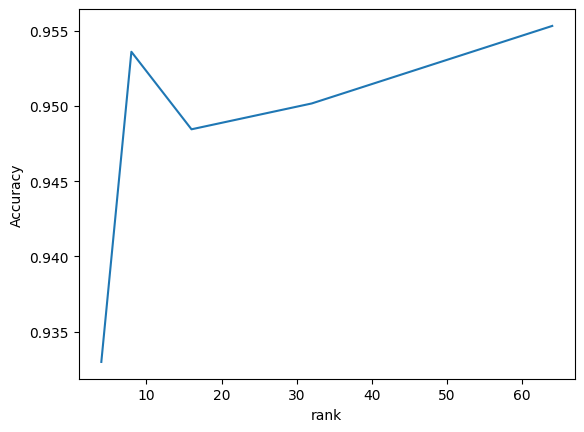

In [49]:
import matplotlib.pyplot as plt

plt.plot([4, 8, 16, 32, 64], [0.93299, 0.953608, 0.948454, 0.950172, 0.955326])
plt.xlabel("rank")
plt.ylabel("Accuracy")

In just a 10 minutes, we have a fine-tuned model with 94% validation accuracy. Also, note that we used a very small subset of the training dataset which is definitely impacting the results. 

In [ ]:
trainer.evaluate(val_ds)